**Assignment**

1. Remember to add your name to the title of the notebook
2. The goal is to explore models that underfit and overfit, and to deal with overfitting by using the techniques seen in class.


In [4]:
# Import needed libraries
import numpy as np
import sys, os, pdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Data:

Consists of the gene expression profile of several cells (coming from a patient). 

There is a train and a test datasets already provided to you.

They are organized as a matrix of cells x genes.

Given a cell, the goal is to predict the correct cell-type based on the genes' expressions for that sample.

___
### By: Moises Britez
git link: [DL-HW-1 notebook folder](https://github.com/moisesbritez92/deep_learning_nbs/tree/main/Notebooks/DL-HW-1)
___

In [5]:
# Cambiar el directorio de trabajo a DL-HW-1
# Este código funciona tanto en Docker local como en Colab
import subprocess
import shutil

target_dir = "DL-HW-1"

# Caso 1: Entorno de contenedor docker donde ya está disponible
# el directorio 'DL-HW-1' practicamente dentro de una VM (ver docker compose). Aquí asumimos que el repositorio ya está presente en el sistema
# de archivos y simplemente cambiamos al directorio. Si no existe, se ejecutará la rama
# de clonación que sigue más abajo.
if os.path.isdir(target_dir):
    os.chdir(target_dir)
    print(f"✓ Directorio cambiado a: {os.getcwd()}")
    print("Contenido:", os.listdir('.'))
# Caso 2: Estamos en Colab - necesitamos clonar
else:
    try:
        print(f"Directorio actual: {os.getcwd()}")
        print(f"Buscando '{target_dir}'...")
        
        # Verificar si git está disponible
        try:
            subprocess.run(["git", "--version"], capture_output=True, text=True, check=True)
            print("✓ Git disponible")
        except (subprocess.CalledProcessError, FileNotFoundError):
            raise RuntimeError("Git no está disponible en este entorno.")
        
        # Limpiar directorio temporal si existe
        temp_dir = "temp_clone_dl"
        if os.path.isdir(temp_dir):
            shutil.rmtree(temp_dir)
            print(f"✓ Limpiado directorio temporal previo")
        
        # Clonar repositorio
        print("Clonando repositorio...")
        subprocess.run(
            ["git", "clone", "https://github.com/moisesbritez92/deep_learning_nbs.git", temp_dir],
            check=True,
            capture_output=True
        )
        print("✓ Repositorio clonado")
        
        # Navegar al subdirectorio correcto
        repo_subpath = os.path.join(temp_dir, "Notebooks", "DL-HW-1")
        
        if not os.path.isdir(repo_subpath):
            # Listar estructura para debug
            print(f"\nEstructura de {temp_dir}:")
            for root, dirs, files in os.walk(temp_dir):
                level = root.replace(temp_dir, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f'{indent}{os.path.basename(root)}/')
                if level < 2:  # Solo 2 niveles de profundidad
                    subindent = ' ' * 2 * (level + 1)
                    for file in files[:5]:  # Solo primeros 5 archivos
                        print(f'{subindent}{file}')
            
            raise FileNotFoundError(f"No se encontró la ruta: {repo_subpath}")
        
        os.chdir(repo_subpath)
        print(f"✓ Directorio cambiado a: {os.getcwd()}")
        print("Contenido:", os.listdir('.'))
        
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"Error al clonar repositorio: {e.stderr if hasattr(e, 'stderr') else str(e)}")
    except Exception as e:
        raise RuntimeError(f"Error inesperado: {str(e)}\nDirectorio actual: {os.getcwd()}")

✓ Directorio cambiado a: /tf/DL-HW-1
Contenido: ['ADI_scRNA_classification.ipynb', 'ADI_scRNA_classification.md', 'model_performance_comparison.png', 'README.md', 'scRNA_Complete_Homework_Solution.ipynb', 'scRNA_Complete_Homework_solution.md', 'scRNA_Complete_Homework_solution_files', 'test.pkl', 'train.pkl']


In [6]:
!ls -la 

total 74640
drwxrwxrwx 1 root root      512 Nov 24 23:37 .
drwxrwxrwx 1 root root      512 Nov 24 23:37 ..
-rwxrwxrwx 1 root root     6411 Nov 21 13:09 ADI_scRNA_classification.ipynb
-rw-r--r-- 1 root root     3121 Nov 21 13:14 ADI_scRNA_classification.md
-rwxrwxrwx 1 root root     3970 Nov 21 14:38 README.md
-rw-r--r-- 1 root root   526110 Nov 23 21:54 model_performance_comparison.png
-rwxrwxrwx 1 root root  1069532 Nov 24 23:39 scRNA_Complete_Homework_Solution.ipynb
-rw-r--r-- 1 root root    83003 Nov 21 16:25 scRNA_Complete_Homework_solution.md
drwxr-xr-x 1 root root      512 Nov 21 16:25 scRNA_Complete_Homework_solution_files
-rwxrwxrwx 1 root root 35623661 Nov 21 12:45 test.pkl
-rwxrwxrwx 1 root root 39098383 Nov 21 12:45 train.pkl


### Nota personal: Entornos corporativos y ejecución de entrenamientos

Me gusta pensar en estos trabajos de Deep Learning como si estuvieran integrados en **entornos corporativos reales**. Por eso estuve experimentando con distintas configuraciones antes de comenzar el entrenamiento formal:

1. **Entorno Docker (local o corporativo)**
   Preparé un contenedor Docker capaz de ejecutarse tanto en mi máquina como en un **servidor corporativo con GPUs**.
   La idea es que este mismo contenedor pueda levantarse en un servidor centralizado que disponga de unidades GPU (por ejemplo, en un centro de datos interno).

   Con esto se puede ejecutar notebooks o scripts directamente en el servidor, dejar entrenamientos largos corriendo sin depender de mi laptop, montar volúmenes para persistir datasets y modelos, e incluso automatizar ejecuciones como **tareas programadas** dentro del propio servidor. Así también, permitiría el trabajo corporativo dentro de la red IT.

2. **Conexión a servicios cloud**
   En un escenario empresarial también es habitual que existan servicios cloud (GCP, AWS, Azure), por lo que **Colab** es una alternativa interesante para validar notebooks de manera rápida, sin instalación local y aprovechando GPUs gratuitas o de bajo costo.
   Por eso agregué la lógica para que este mismo notebook pueda ejecutarse tanto dentro del contenedor Docker como en Colab.

3. **Entorno virtualenv local**
   Además del Docker, si uno quiere lanzar todo de manera local recomendaría levantar un entorno Python local con `virtualenv`/`venv` utilizando los `requirements.txt` que están en este repositorio.
   Esto permite tener otra opción más flexible para pruebas rápidas o para entornos donde Docker no está disponible.

4. **Repositorio organizado para ambos mundos**
   Todo el setup —incluyendo `requirements.txt` y el propio **Dockerfile**— está dentro del repositorio.
---


In [7]:
# Importar TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

tf.random.set_seed(42)
print(f"TensorFlow version: {tf.__version__}")

2025-11-24 23:43:50.115388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 23:43:50.521094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-24 23:43:50.521212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-24 23:43:50.589956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-24 23:43:50.722453: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.15.0


In [8]:
# Ver estado de la GPU (usa tensorflow y nvidia-smi si están disponibles)
print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', None))

# Información desde TensorFlow (si tf ya está importado en el kernel)
try:
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        print("TensorFlow: No se detectaron GPUs.")
    else:
        print(f"TensorFlow: {len(gpus)} GPU(s) detectada(s).")
        for i, gpu in enumerate(gpus):
            print(f" GPU #{i}: {gpu}")
            try:
                details = tf.config.experimental.get_device_details(gpu)
                if details:
                    for k, v in details.items():
                        print(f"   {k}: {v}")
            except Exception:
                pass
        # Intentar activar memory growth (evita que TF reserve toda la memoria)
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth activado en GPUs (si fue posible).")
        except Exception as e:
            print("No se pudo activar memory growth:", e)
except NameError:
    print("TensorFlow no está importado en este kernel (variable 'tf' no definida).")

# Información desde nvidia-smi (si está disponible en el sistema)
print("\nComprobando 'nvidia-smi'...")
try:
    out = subprocess.run(
        ['nvidia-smi', '--query-gpu=index,name,memory.total,memory.used,utilization.gpu',
         '--format=csv,noheader,nounits'],
        capture_output=True, text=True, check=True
    )
    lines = [l.strip() for l in out.stdout.strip().splitlines() if l.strip()]
    if not lines:
        print("nvidia-smi no devolvió información útil.")
    else:
        for line in lines:
            idx, name, mem_total, mem_used, util = [s.strip() for s in line.split(',')]
            print(f" GPU {idx}: {name} | Memoria: {mem_used}/{mem_total} MiB | Utilización: {util}%")
except FileNotFoundError:
    print("nvidia-smi no encontrado en el sistema.")
except subprocess.CalledProcessError as e:
    print("Error ejecutando nvidia-smi:", e.stderr or e)

CUDA_VISIBLE_DEVICES: None
TensorFlow: 1 GPU(s) detectada(s).
 GPU #0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   compute_capability: (8, 6)
   device_name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Memory growth activado en GPUs (si fue posible).

Comprobando 'nvidia-smi'...
 GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU | Memoria: 0/8192 MiB | Utilización: 0%
 GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU | Memoria: 0/8192 MiB | Utilización: 0%


2025-11-24 23:43:55.285939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:55.391645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:55.391780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:55.392340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
# Load data

# Path to source batch
train_path = "train.pkl"
# Path to target batch
test_path = "test.pkl"
# Column containing cell-types
lname = "labels" 

train_batch = pd.read_pickle(train_path)
test_batch = pd.read_pickle(test_path)

In [10]:
train_batch

index,HES4,ISG15,TNFRSF18,TNFRSF4,MMP23B,UTS2,TNFRSF9,RBP7,PGD,AGTRAP,...,AP000692.10,BACE2,MX1,AP001059.6,AIRE,COL6A2,S100B,MT-ATP8,MT-ND6,labels
index,,,,,,,,,,,,,,,,,,,,,
data_3p-AAACCTGAGCATCATC-0,-0.196407,2.163650,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,-0.410718,-0.578313,-0.609471,...,-0.100605,-0.169544,3.396856,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,B cell
data_3p-AAACCTGAGCTAGTGG-0,-0.196407,1.371853,-0.186414,8.028668,-0.130663,-0.079505,-0.089647,-0.410718,1.221355,-0.609471,...,-0.100605,-0.169544,-0.382577,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,-0.410718,1.770606,-0.609471,...,-0.100605,-0.169544,-0.382577,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,0.840558,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,2.437211,-0.578313,1.062532,...,-0.100605,-0.169544,-0.382577,8.922243,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,1.606579,-0.578313,1.112563,...,-0.100605,-0.169544,-0.382577,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,Monocyte_CD14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
data_3p-TTTGTCATCATGTCCC-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,-0.410718,-0.578313,-0.609471,...,-0.100605,-0.169544,-0.382577,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,CD8 T cell
data_3p-TTTGTCATCCGATATG-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,-0.410718,-0.578313,-0.609471,...,-0.100605,-0.169544,2.025987,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,0.335671,CD8 T cell
data_3p-TTTGTCATCGTCTGAA-0,-0.196407,-0.564395,-0.186414,-0.222519,-0.130663,-0.079505,-0.089647,1.252710,0.921344,-0.609471,...,-0.100605,-0.169544,-0.382577,-0.099155,-0.064381,-0.186117,-0.077992,-0.931465,-0.777325,Monocyte_CD14


In [11]:
# Extract the common genes so that we can use the same network for both batches

common_genes = list(set(train_batch.columns).intersection(set(test_batch.columns)))
common_genes.sort()
train_batch = train_batch[list(common_genes)]
test_batch = test_batch[list(common_genes)]

train_mat = train_batch.drop(lname, axis=1)
train_labels = train_batch[lname]

test_mat = test_batch.drop(lname, axis=1)
test_labels = test_batch[lname]

# values are already normalized (ignore this)
mat = train_mat.values
mat_round = np.rint(mat)
error = np.mean(np.abs(mat - mat_round))


In [12]:
print(len(test_labels.unique()), len(train_labels.unique()))

9 9


## 2. Preguntas Teoricas (Q1-Q6)

### Q1: Que tipo de problema estamos resolviendo?

**Respuesta:** Problema de clasificacion multiclase. Dado el perfil de expresion genica de una celula, predecir su tipo celular.

### Q2: Cual es el tamano de la entrada (numero de features)?

**Respuesta:** El numero de genes comunes entre train y test es 9.

### Q3: Cuantas neuronas debemos tener en la ultima capa?

**Respuesta:** Una neurona por cada clase (tipo celular).

### Q4: Cual es la funcion de activacion mas apropiada para la ultima capa?

**Respuesta:** Softmax, para obtener probabilidades que sumen 1.


In [13]:
# Procesar etiquetas: convertir a enteros y one-hot
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels_int = label_encoder.fit_transform(train_labels)
test_labels_int = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
n_features = train_mat.shape[1]

train_labels_onehot = to_categorical(train_labels_int, num_classes)
test_labels_onehot = to_categorical(test_labels_int, num_classes)

print(f"Numero de clases: {num_classes}")
print(f"Numero de features: {n_features}")
print(f"Mapeo: {dict(zip(label_encoder.classes_, range(num_classes)))}")


Numero de clases: 9
Numero de features: 1199
Mapeo: {'B cell': 0, 'CD4 T cell': 1, 'CD8 T cell': 2, 'Hematopoietic stem cell': 3, 'Megakaryocyte': 4, 'Monocyte_CD14': 5, 'Monocyte_FCGR3A': 6, 'NK cell': 7, 'Plasmacytoid dendritic cell': 8}


### Q5: Como se modificaron las etiquetas?

**Respuesta:** Se convirtieron de textos a enteros (LabelEncoder) y luego a one-hot encoding para usar con categorical_crossentropy.

### Q6: Que funcion de perdida se usara?

**Respuesta:** Categorical cross-entropy, la perdida estandar para clasificacion multiclase con one-hot encoding.


## 3. Entrenamiento de Modelos

Entrenaremos 3 modelos sin regularizacion:
1. Underfit: Muy pocas capas/neuronas
2. OK: Arquitectura razonable
3. Overfit: Muchas capas/neuronas

Luego aplicaremos regularizacion (L2, Dropout) al modelo que overfitea.


In [14]:
# Preparar datos
from sklearn.model_selection import train_test_split

X_train_full = train_mat.values.astype('float32')
X_test = test_mat.values.astype('float32')
y_train_full = train_labels_onehot
y_test = test_labels_onehot

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42,
    stratify=np.argmax(y_train_full, axis=1)
)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")


X_train: (6478, 1199), X_val: (1620, 1199), X_test: (7378, 1199)


### Modelo 1: Underfit


In [15]:
# Modelo con capacidad insuficiente
def create_underfit_model():
    model = models.Sequential([
        layers.Dense(16, activation='relu', input_shape=(n_features,)),
        layers.Dense(num_classes, activation='softmax')
    ], name='Underfit')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_underfit = create_underfit_model()
model_underfit.summary()


Model: "Underfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                19200     
                                                                 
 dense_1 (Dense)             (None, 9)                 153       
                                                                 
Total params: 19353 (75.60 KB)
Trainable params: 19353 (75.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                19200     
                                                                 
 dense_1 (Dense)             (None, 9)                 153       
                                                                 
Total params: 19353 (7

2025-11-24 23:43:57.157277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:57.157358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:57.157374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:58.105249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 23:43:58.105310: I external/local_xla/xla/stream_executor

In [16]:
# Entrenar modelo underfit
history_underfit = model_underfit.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Train acc: {history_underfit.history['accuracy'][-1]:.4f}")
print(f"Val acc: {history_underfit.history['val_accuracy'][-1]:.4f}")


Epoch 1/50


2025-11-24 23:43:59.185868: I external/local_xla/xla/service/service.cc:168] XLA service 0x752370d384a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 23:43:59.185903: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-11-24 23:43:59.200616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 23:43:59.233916: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1764027839.294839     151 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 [==============================] - 2s 5ms/step - loss: 0.4083 - accuracy: 0.8771 - val_loss: 0.0983 - val_accuracy: 0.9685
Epoch 2/50
203/203 [==============================] - 2s 5ms/step - loss: 0.4083 - accuracy: 0.8771 - val_loss: 0.0983 - val_accuracy: 0.9685
Epoch 2/50
203/203 [==============================] - 1s 4ms/step - loss: 0.0571 - accuracy: 0.9838 - val_loss: 0.0604 - val_accuracy: 0.9796
Epoch 3/50
203/203 [==============================] - 1s 4ms/step - loss: 0.0571 - accuracy: 0.9838 - val_loss: 0.0604 - val_accuracy: 0.9796
Epoch 3/50
203/203 [==============================] - 1s 5ms/step - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.0531 - val_accuracy: 0.9815
Epoch 4/50
203/203 [==============================] - 1s 5ms/step - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.0531 - val_accuracy: 0.9815
Epoch 4/50
203/203 [==============================] - 1s 5ms/step - loss: 0.0153 - accuracy: 0.9981 - val_loss: 0.0517 - val_accuracy: 0.9840
Epoch 5/50
203/20

### Modelo 2: Buen Ajustado


In [17]:
# Modelo con capacidad adecuada
def create_ok_model():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(n_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='OK')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_ok = create_ok_model()
model_ok.summary()


Model: "OK"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               153600    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 9)                 297       
                                                                 
Total params: 164233 (641.54 KB)
Trainable params: 164233 (641.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)        

In [18]:
# Entrenar modelo OK
history_ok = model_ok.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Train acc: {history_ok.history['accuracy'][-1]:.4f}")
print(f"Val acc: {history_ok.history['val_accuracy'][-1]:.4f}")


Epoch 1/50
203/203 [==============================] - 2s 7ms/step - loss: 0.2403 - accuracy: 0.9205 - val_loss: 0.0665 - val_accuracy: 0.9747
Epoch 2/50
203/203 [==============================] - 2s 7ms/step - loss: 0.2403 - accuracy: 0.9205 - val_loss: 0.0665 - val_accuracy: 0.9747
Epoch 2/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0280 - accuracy: 0.9903 - val_loss: 0.0638 - val_accuracy: 0.9741
Epoch 3/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0280 - accuracy: 0.9903 - val_loss: 0.0638 - val_accuracy: 0.9741
Epoch 3/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0157 - accuracy: 0.9935 - val_loss: 0.0631 - val_accuracy: 0.9759
Epoch 4/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0157 - accuracy: 0.9935 - val_loss: 0.0631 - val_accuracy: 0.9759
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0682 - val_accuracy: 0.9802
Epoch 

### Modelo 3: Overfit


In [19]:
# Modelo con capacidad excesiva
def create_overfit_model():
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_features,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='Overfit')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_overfit = create_overfit_model()
model_overfit.summary()


Model: "Overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               614400    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 1108233 (4.23 MB)
Trainable params: 1108233 (

In [20]:
# Entrenar modelo overfit
history_overfit = model_overfit.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Train acc: {history_overfit.history['accuracy'][-1]:.4f}")
print(f"Val acc: {history_overfit.history['val_accuracy'][-1]:.4f}")
print(f"Gap: {history_overfit.history['accuracy'][-1] - history_overfit.history['val_accuracy'][-1]:.4f}")


Epoch 1/50
203/203 [==============================] - 3s 9ms/step - loss: 0.1953 - accuracy: 0.9339 - val_loss: 0.0984 - val_accuracy: 0.9642
Epoch 2/50
203/203 [==============================] - 3s 9ms/step - loss: 0.1953 - accuracy: 0.9339 - val_loss: 0.0984 - val_accuracy: 0.9642
Epoch 2/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.0700 - val_accuracy: 0.9753
Epoch 3/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.0700 - val_accuracy: 0.9753
Epoch 3/50
203/203 [==============================] - 1s 7ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0786 - val_accuracy: 0.9747
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0786 - val_accuracy: 0.9747
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.0833 - val_accuracy: 0.9778
Epoc

### Visualizacion de Resultados


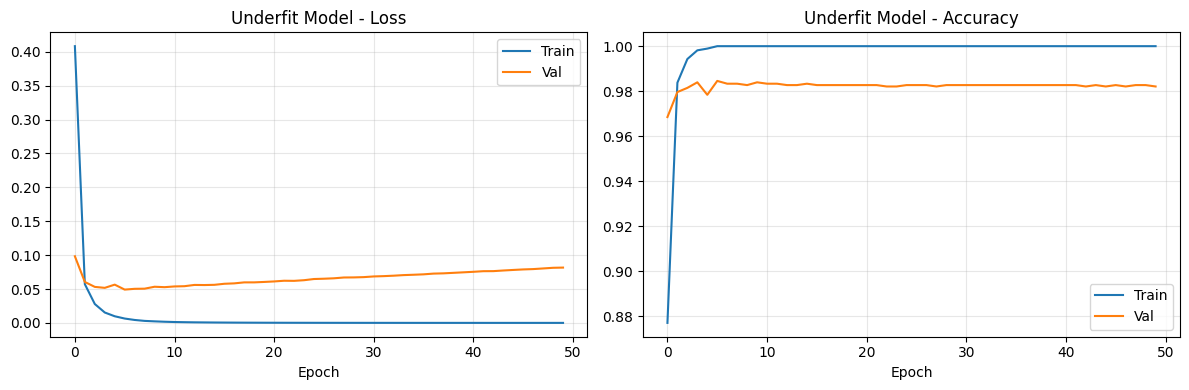

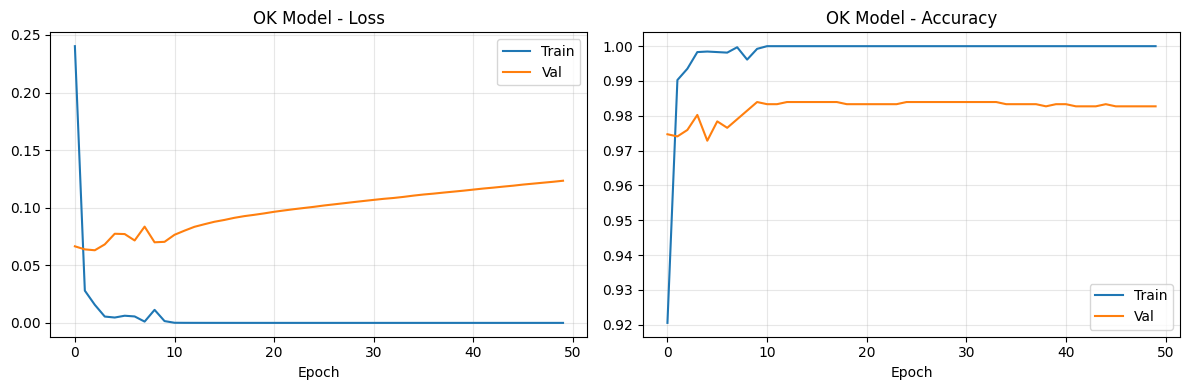

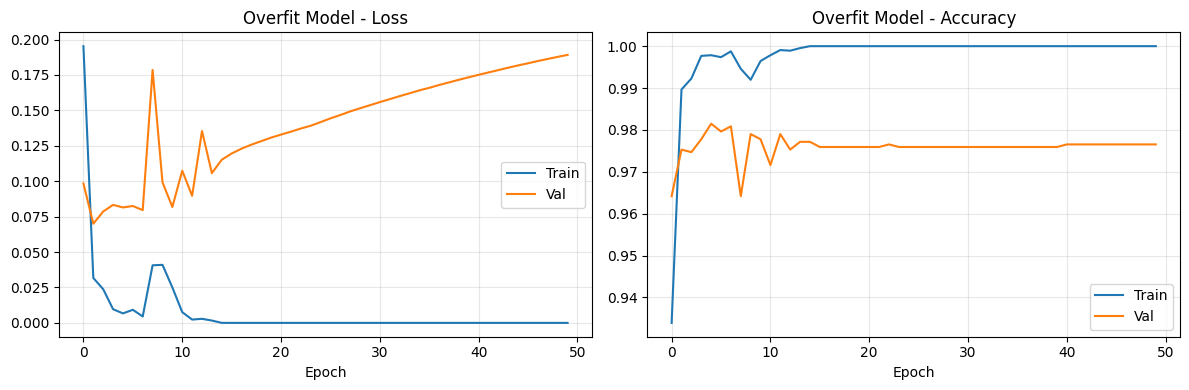

In [21]:
# Graficar curvas de entrenamiento
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Val')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Val')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_history(history_underfit, 'Underfit Model')
plot_history(history_ok, 'OK Model')
plot_history(history_overfit, 'Overfit Model')


Modelo Ok, con 5 epocas de entrenamiento suficiente para evitar overfitting.

In [22]:
model_ok_5 = create_ok_model()
model_ok_5.summary()
# Entrenar modelo OK 5 epocas
history_ok_5 = model_ok_5.fit(
    X_train, y_train, epochs=5, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Train acc: {history_ok.history['accuracy'][-1]:.4f}")
print(f"Val acc: {history_ok.history['val_accuracy'][-1]:.4f}")

Model: "OK"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               153600    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 9)                 297       
                                                                 
Total params: 164233 (641.54 KB)
Trainable params: 164233 (641.54 KB)
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               153600    
                                                            

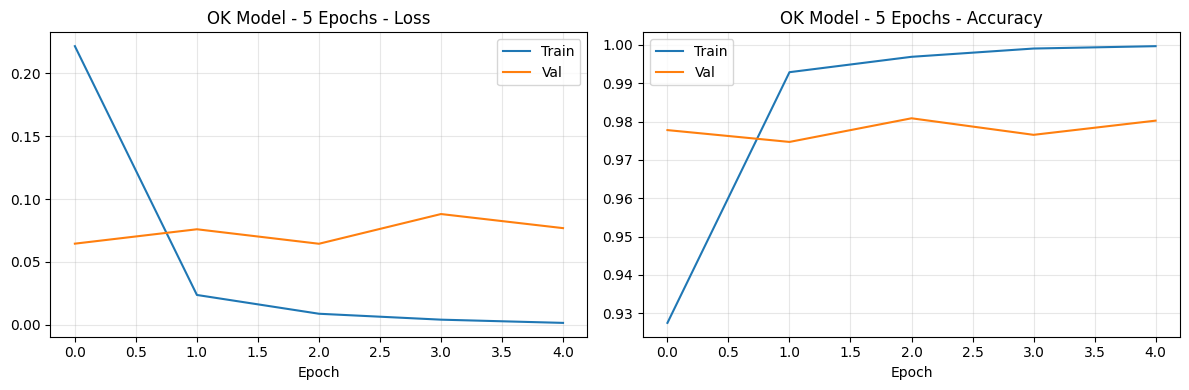

In [23]:
plot_history(history_ok_5, 'OK Model - 5 Epochs')

## 4. Regularizacion

Aplicaremos L2 y Dropout al modelo que overfit.


### Regularizacion L2


In [24]:
# Modelo con L2 regularization
def create_l2_model(l2_lambda=0.001):
    model = models.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(n_features,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(num_classes, activation='softmax')
    ], name=f'L2_{l2_lambda}')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_l2 = create_l2_model(0.001)
history_l2 = model_l2.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"L2 Model - Train acc: {history_l2.history['accuracy'][-1]:.4f}")
print(f"L2 Model - Val acc: {history_l2.history['val_accuracy'][-1]:.4f}")
print(f"L2 Model - Gap: {history_l2.history['accuracy'][-1] - history_l2.history['val_accuracy'][-1]:.4f}")


Epoch 1/50
203/203 [==============================] - 3s 9ms/step - loss: 1.5546 - accuracy: 0.9319 - val_loss: 0.9964 - val_accuracy: 0.9747
Epoch 2/50
203/203 [==============================] - 3s 9ms/step - loss: 1.5546 - accuracy: 0.9319 - val_loss: 0.9964 - val_accuracy: 0.9747
Epoch 2/50
203/203 [==============================] - 1s 7ms/step - loss: 0.7170 - accuracy: 0.9877 - val_loss: 0.5646 - val_accuracy: 0.9778
Epoch 3/50
203/203 [==============================] - 1s 7ms/step - loss: 0.7170 - accuracy: 0.9877 - val_loss: 0.5646 - val_accuracy: 0.9778
Epoch 3/50
203/203 [==============================] - 1s 7ms/step - loss: 0.4187 - accuracy: 0.9918 - val_loss: 0.3917 - val_accuracy: 0.9710
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.4187 - accuracy: 0.9918 - val_loss: 0.3917 - val_accuracy: 0.9710
Epoch 4/50
203/203 [==============================] - 2s 8ms/step - loss: 0.2979 - accuracy: 0.9898 - val_loss: 0.3072 - val_accuracy: 0.9722
Epoch 

### Regularizacion Dropout


In [25]:
# Modelo con Dropout
def create_dropout_model(dropout_rate=0.5):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_features,)),
        layers.Dropout(dropout_rate),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ], name=f'Dropout_{dropout_rate}')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_dropout = create_dropout_model(0.5)
history_dropout = model_dropout.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Dropout Model - Train acc: {history_dropout.history['accuracy'][-1]:.4f}")
print(f"Dropout Model - Val acc: {history_dropout.history['val_accuracy'][-1]:.4f}")
print(f"Dropout Model - Gap: {history_dropout.history['accuracy'][-1] - history_dropout.history['val_accuracy'][-1]:.4f}")


Epoch 1/50
203/203 [==============================] - 3s 9ms/step - loss: 1.1154 - accuracy: 0.5897 - val_loss: 0.2946 - val_accuracy: 0.8895
Epoch 2/50
203/203 [==============================] - 3s 9ms/step - loss: 1.1154 - accuracy: 0.5897 - val_loss: 0.2946 - val_accuracy: 0.8895
Epoch 2/50
203/203 [==============================] - 2s 8ms/step - loss: 0.3196 - accuracy: 0.8986 - val_loss: 0.0718 - val_accuracy: 0.9802
Epoch 3/50
203/203 [==============================] - 2s 8ms/step - loss: 0.3196 - accuracy: 0.8986 - val_loss: 0.0718 - val_accuracy: 0.9802
Epoch 3/50
203/203 [==============================] - 1s 7ms/step - loss: 0.1620 - accuracy: 0.9566 - val_loss: 0.0586 - val_accuracy: 0.9802
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.1620 - accuracy: 0.9566 - val_loss: 0.0586 - val_accuracy: 0.9802
Epoch 4/50
203/203 [==============================] - 1s 7ms/step - loss: 0.1113 - accuracy: 0.9704 - val_loss: 0.0518 - val_accuracy: 0.9833
Epoch 

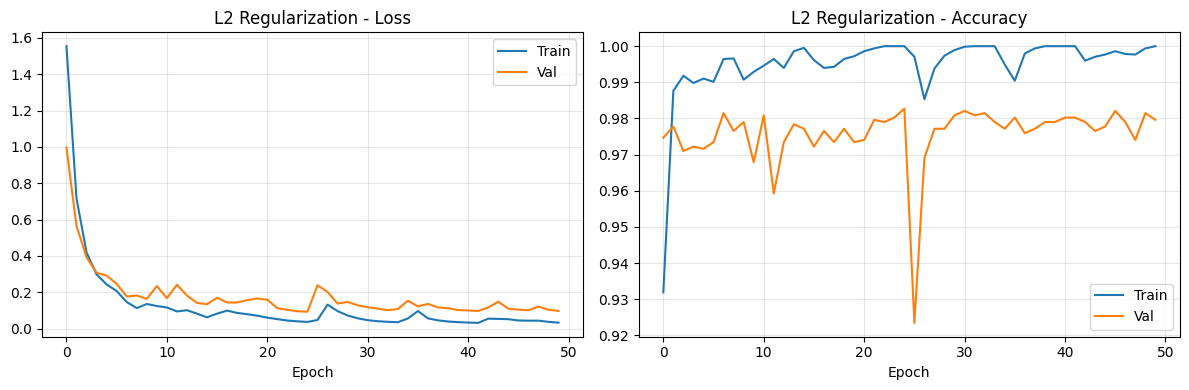

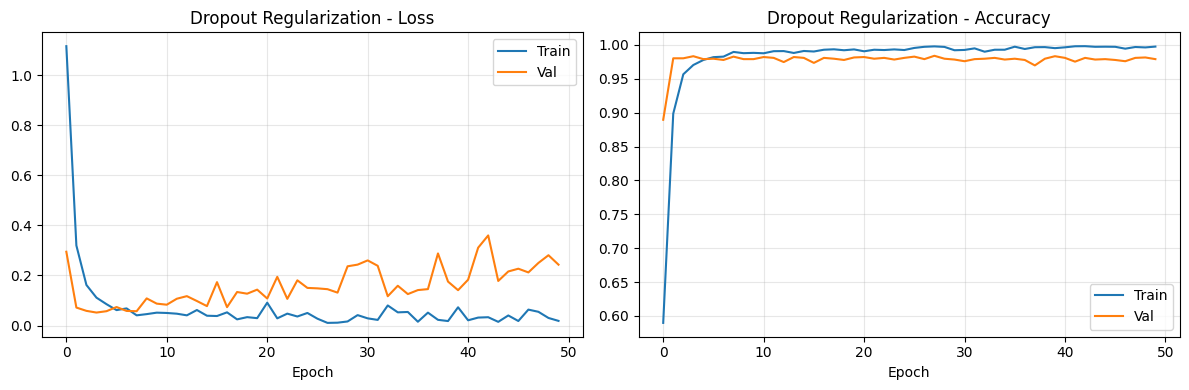


Comparacion:
Sin reg - Gap: 0.0235
L2      - Gap: 0.0204
Dropout - Gap: 0.0185


In [26]:
# Comparacion de regularizacion
plot_history(history_l2, 'L2 Regularization')
plot_history(history_dropout, 'Dropout Regularization')

print("\nComparacion:")
print(f"Sin reg - Gap: {history_overfit.history['accuracy'][-1] - history_overfit.history['val_accuracy'][-1]:.4f}")
print(f"L2      - Gap: {history_l2.history['accuracy'][-1] - history_l2.history['val_accuracy'][-1]:.4f}")
print(f"Dropout - Gap: {history_dropout.history['accuracy'][-1] - history_dropout.history['val_accuracy'][-1]:.4f}")


Modelo regularizado con L2, con 45 epocas de entrenamiento.

In [27]:
model_l2_45 = create_l2_model(0.001)
history_l2_45 = model_l2_45.fit(
    X_train, y_train, epochs=45, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"L2 Model 45  - Train acc: {history_l2_45.history['accuracy'][-1]:.4f}")
print(f"L2 Model 45  - Val acc: {history_l2_45.history['val_accuracy'][-1]:.4f}")
print(f"L2 Model 45  - Gap: {history_l2_45.history['accuracy'][-1] - history_l2_45.history['val_accuracy'][-1]:.4f}")

Epoch 1/45
203/203 [==============================] - 3s 9ms/step - loss: 1.5853 - accuracy: 0.9352 - val_loss: 1.0196 - val_accuracy: 0.9809
Epoch 2/45
203/203 [==============================] - 3s 9ms/step - loss: 1.5853 - accuracy: 0.9352 - val_loss: 1.0196 - val_accuracy: 0.9809
Epoch 2/45
203/203 [==============================] - 1s 7ms/step - loss: 0.7434 - accuracy: 0.9887 - val_loss: 0.5711 - val_accuracy: 0.9796
Epoch 3/45
203/203 [==============================] - 1s 7ms/step - loss: 0.7434 - accuracy: 0.9887 - val_loss: 0.5711 - val_accuracy: 0.9796
Epoch 3/45
203/203 [==============================] - 1s 7ms/step - loss: 0.4635 - accuracy: 0.9839 - val_loss: 0.4083 - val_accuracy: 0.9759
Epoch 4/45
203/203 [==============================] - 1s 7ms/step - loss: 0.4635 - accuracy: 0.9839 - val_loss: 0.4083 - val_accuracy: 0.9759
Epoch 4/45
203/203 [==============================] - 2s 7ms/step - loss: 0.3282 - accuracy: 0.9881 - val_loss: 0.3147 - val_accuracy: 0.9827
Epoch 

Modelo Regularizado con Dropout, con 20 epocas de entrenamiento.

In [28]:
# Modelo con Dropout con 20 epocas
model_dropout_20 = create_dropout_model(0.5)
history_dropout_20 = model_dropout_20.fit(
    X_train, y_train, epochs=20, batch_size=32,
    validation_data=(X_val, y_val), verbose=1
)

print(f"Dropout Model 20 epocas - Train acc: {history_dropout_20.history['accuracy'][-1]:.4f}")
print(f"Dropout Model 20 epocas - Val acc: {history_dropout_20.history['val_accuracy'][-1]:.4f}")
print(f"Dropout Model 20 epocas - Gap: {history_dropout_20.history['accuracy'][-1] - history_dropout_20.history['val_accuracy'][-1]:.4f}")

Epoch 1/20
203/203 [==============================] - 3s 8ms/step - loss: 1.0719 - accuracy: 0.6054 - val_loss: 0.2607 - val_accuracy: 0.9136
Epoch 2/20
203/203 [==============================] - 3s 8ms/step - loss: 1.0719 - accuracy: 0.6054 - val_loss: 0.2607 - val_accuracy: 0.9136
Epoch 2/20
203/203 [==============================] - 3s 14ms/step - loss: 0.3083 - accuracy: 0.9049 - val_loss: 0.0684 - val_accuracy: 0.9772
Epoch 3/20
203/203 [==============================] - 3s 14ms/step - loss: 0.3083 - accuracy: 0.9049 - val_loss: 0.0684 - val_accuracy: 0.9772
Epoch 3/20
203/203 [==============================] - 2s 7ms/step - loss: 0.1620 - accuracy: 0.9574 - val_loss: 0.0600 - val_accuracy: 0.9815
Epoch 4/20
203/203 [==============================] - 2s 7ms/step - loss: 0.1620 - accuracy: 0.9574 - val_loss: 0.0600 - val_accuracy: 0.9815
Epoch 4/20
203/203 [==============================] - 1s 7ms/step - loss: 0.1117 - accuracy: 0.9724 - val_loss: 0.0571 - val_accuracy: 0.9809
Epoc

## 5. Evaluacion en Test Set

Evaluaremos el mejor modelo en el conjunto de test.


In [29]:
test_loss_ok_5, test_acc_ok_5 = model_ok_5.evaluate(X_test, y_test, verbose=1)
print(f"OK Model 5 Epochs - Test acc: {test_acc_ok_5:.4f}")
print(f"OK Model 5 Epochs - Test loss: {test_loss_ok_5:.4f}")

231/231 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.9619
OK Model 5 Epochs - Test acc: 0.9619
OK Model 5 Epochs - Test loss: 0.1517
231/231 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.9619
OK Model 5 Epochs - Test acc: 0.9619
OK Model 5 Epochs - Test loss: 0.1517


In [30]:
test_loss_overfit, test_acc_overfit = model_overfit.evaluate(X_test, y_test, verbose=1)
print(f"Overfit Model - Test acc: {test_acc_overfit:.4f}")
print(f"Overfit Model - Test loss: {test_loss_overfit:.4f}")

231/231 [==============================] - 1s 4ms/step - loss: 0.5314 - accuracy: 0.9557
Overfit Model - Test acc: 0.9557
Overfit Model - Test loss: 0.5314
231/231 [==============================] - 1s 4ms/step - loss: 0.5314 - accuracy: 0.9557
Overfit Model - Test acc: 0.9557
Overfit Model - Test loss: 0.5314


In [31]:
test_loss_underfit, test_acc_underfit = model_underfit.evaluate(X_test, y_test, verbose=1)
print(f"Underfit Model - Test acc: {test_acc_underfit:.4f}")
print(f"Underfit Model - Test loss: {test_loss_underfit:.4f}")

231/231 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.9225
Underfit Model - Test acc: 0.9225
Underfit Model - Test loss: 0.3056
231/231 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.9225
Underfit Model - Test acc: 0.9225
Underfit Model - Test loss: 0.3056


In [32]:
# Evaluar en test set modelo OK
test_loss, test_acc = model_ok.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


231/231 [==============================] - 1s 4ms/step - loss: 0.3360 - accuracy: 0.9591
Test Loss: 0.3360
Test Accuracy: 0.9591
231/231 [==============================] - 1s 4ms/step - loss: 0.3360 - accuracy: 0.9591
Test Loss: 0.3360
Test Accuracy: 0.9591


In [33]:
# Evaluar en test set modelo Dropout
test_loss_drop, test_acc_drop = model_dropout.evaluate(X_test, y_test, verbose=1)
print(f"Dropout Model - Test Loss: {test_loss_drop:.4f}")
print(f"Dropout Model - Test Accuracy: {test_acc_drop:.4f}")

231/231 [==============================] - 1s 4ms/step - loss: 0.9470 - accuracy: 0.9337
Dropout Model - Test Loss: 0.9470
Dropout Model - Test Accuracy: 0.9337
Dropout Model - Test Loss: 0.9470
Dropout Model - Test Accuracy: 0.9337


In [34]:
# Evaluar en test set modelo Dropout 20 epocas
test_loss_drop_20, test_acc_drop_20 = model_dropout_20.evaluate(X_test, y_test, verbose=1)
print(f"Dropout Model 20 epocas - Test Loss: {test_loss_drop_20:.4f}")
print(f"Dropout Model 20 epocas - Test Accuracy: {test_acc_drop_20:.4f}")

231/231 [==============================] - 1s 4ms/step - loss: 0.7048 - accuracy: 0.9451
Dropout Model 20 epocas - Test Loss: 0.7048
Dropout Model 20 epocas - Test Accuracy: 0.9451
231/231 [==============================] - 1s 4ms/step - loss: 0.7048 - accuracy: 0.9451
Dropout Model 20 epocas - Test Loss: 0.7048
Dropout Model 20 epocas - Test Accuracy: 0.9451


In [35]:
# Evaluar en test set modelo L2
test_loss_l2, test_acc_l2 = model_l2.evaluate(X_test, y_test, verbose=1)
print(f"L2 Model - Test Loss: {test_loss_l2:.4f}")  
print(f"L2 Model - Test Accuracy: {test_acc_l2:.4f}")

231/231 [==============================] - 1s 5ms/step - loss: 0.1783 - accuracy: 0.9664
L2 Model - Test Loss: 0.1783
L2 Model - Test Accuracy: 0.9664
231/231 [==============================] - 1s 5ms/step - loss: 0.1783 - accuracy: 0.9664
L2 Model - Test Loss: 0.1783
L2 Model - Test Accuracy: 0.9664


In [36]:
# Evaluar modelo L2 con 45 epochs
test_loss_l2_45, test_acc_l2_45 = model_l2_45.evaluate(X_test, y_test, verbose=1)
print(f"L2 Model 45 - Test Loss: {test_loss_l2_45:.4f}")  
print(f"L2 Model 45 - Test Accuracy: {test_acc_l2_45:.4f}")

231/231 [==============================] - 1s 5ms/step - loss: 0.2822 - accuracy: 0.9513
L2 Model 45 - Test Loss: 0.2822
L2 Model 45 - Test Accuracy: 0.9513
231/231 [==============================] - 1s 5ms/step - loss: 0.2822 - accuracy: 0.9513
L2 Model 45 - Test Loss: 0.2822
L2 Model 45 - Test Accuracy: 0.9513


231/231 [==============================] - 0s 1ms/step


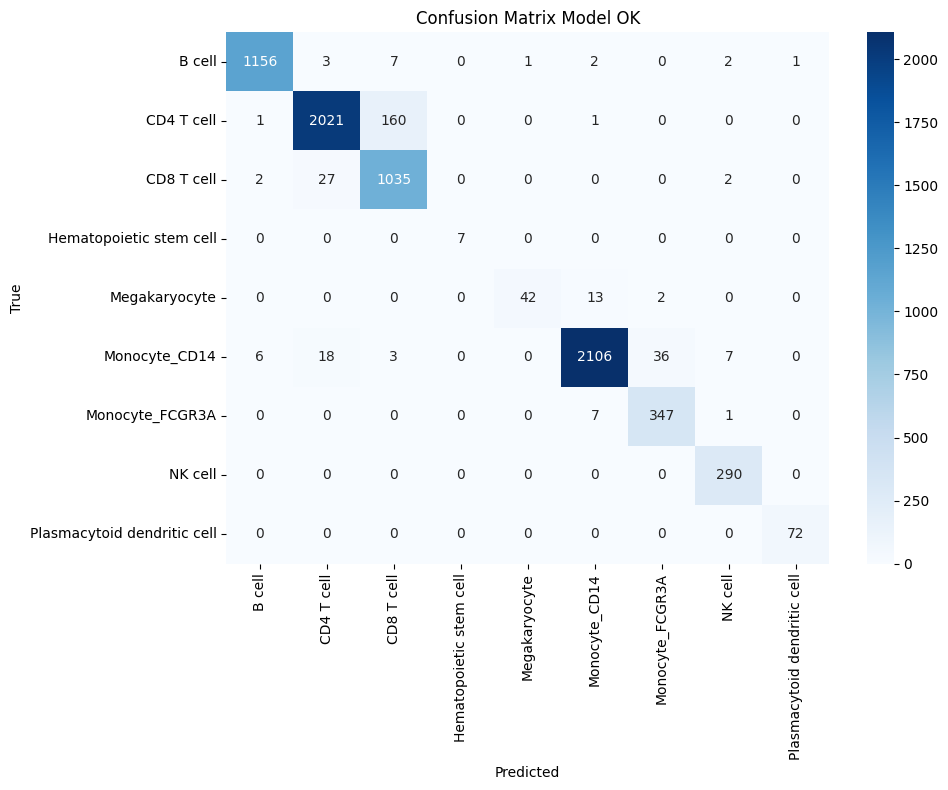


Classification Report:
                             precision    recall  f1-score   support

                     B cell       0.99      0.99      0.99      1172
                 CD4 T cell       0.98      0.93      0.95      2183
                 CD8 T cell       0.86      0.97      0.91      1066
    Hematopoietic stem cell       1.00      1.00      1.00         7
              Megakaryocyte       0.98      0.74      0.84        57
              Monocyte_CD14       0.99      0.97      0.98      2176
            Monocyte_FCGR3A       0.90      0.98      0.94       355
                    NK cell       0.96      1.00      0.98       290
Plasmacytoid dendritic cell       0.99      1.00      0.99        72

                   accuracy                           0.96      7378
                  macro avg       0.96      0.95      0.95      7378
               weighted avg       0.96      0.96      0.96      7378



In [37]:
# Matriz de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model_ok.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Model OK')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))


231/231 [==============================] - 0s 2ms/step


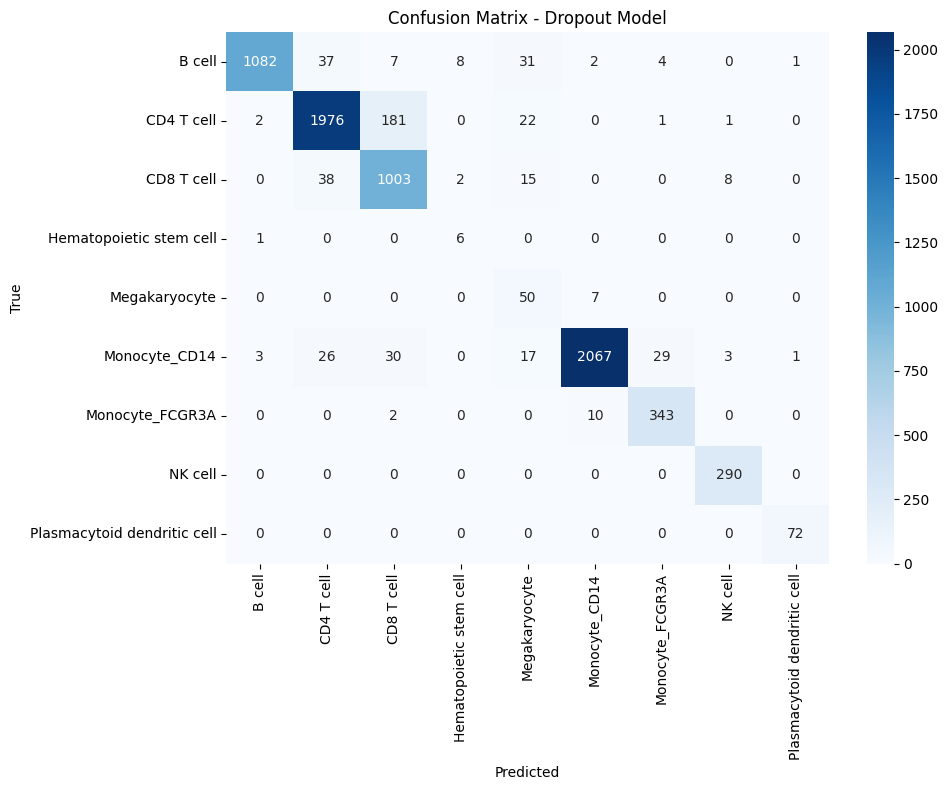


Classification Report - Dropout Model:
                             precision    recall  f1-score   support

                     B cell       0.99      0.92      0.96      1172
                 CD4 T cell       0.95      0.91      0.93      2183
                 CD8 T cell       0.82      0.94      0.88      1066
    Hematopoietic stem cell       0.38      0.86      0.52         7
              Megakaryocyte       0.37      0.88      0.52        57
              Monocyte_CD14       0.99      0.95      0.97      2176
            Monocyte_FCGR3A       0.91      0.97      0.94       355
                    NK cell       0.96      1.00      0.98       290
Plasmacytoid dendritic cell       0.97      1.00      0.99        72

                   accuracy                           0.93      7378
                  macro avg       0.82      0.94      0.85      7378
               weighted avg       0.94      0.93      0.94      7378



In [38]:
# Matriz de confusion
y_pred = model_dropout.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Dropout Model')
plt.tight_layout()
plt.show()

print("\nClassification Report - Dropout Model:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

231/231 [==============================] - 0s 2ms/step


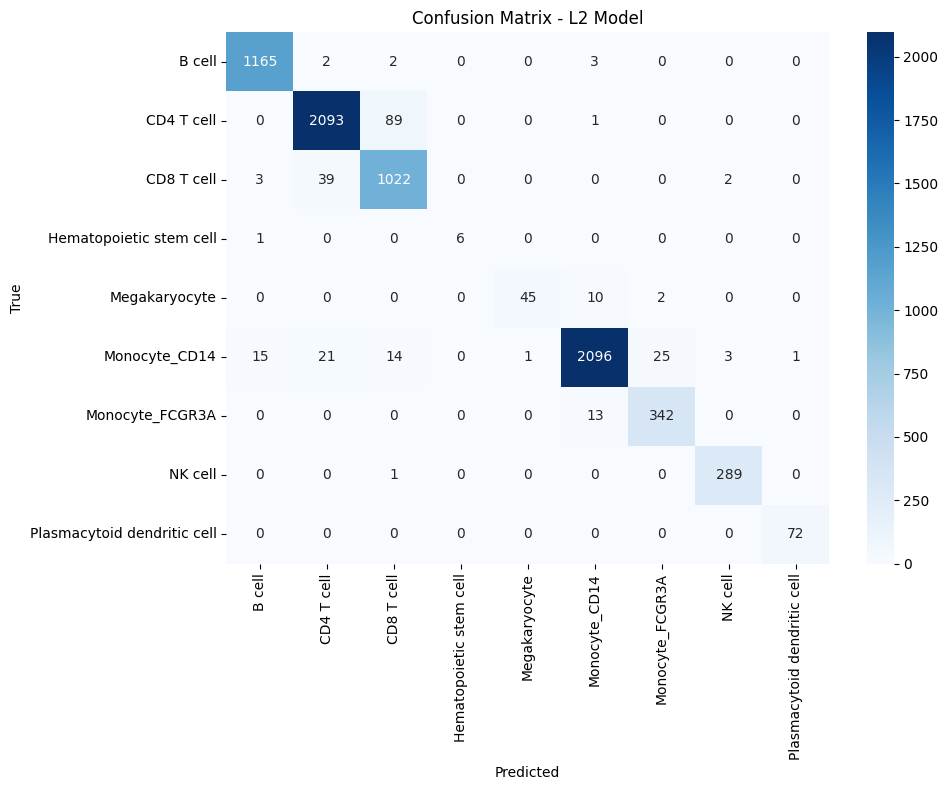


Classification Report - L2 Model:
                             precision    recall  f1-score   support

                     B cell       0.98      0.99      0.99      1172
                 CD4 T cell       0.97      0.96      0.96      2183
                 CD8 T cell       0.91      0.96      0.93      1066
    Hematopoietic stem cell       1.00      0.86      0.92         7
              Megakaryocyte       0.98      0.79      0.87        57
              Monocyte_CD14       0.99      0.96      0.98      2176
            Monocyte_FCGR3A       0.93      0.96      0.94       355
                    NK cell       0.98      1.00      0.99       290
Plasmacytoid dendritic cell       0.99      1.00      0.99        72

                   accuracy                           0.97      7378
                  macro avg       0.97      0.94      0.95      7378
               weighted avg       0.97      0.97      0.97      7378



In [39]:
y_pred = model_l2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - L2 Model')
plt.tight_layout()
plt.show()

print("\nClassification Report - L2 Model:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

231/231 [==============================] - 0s 2ms/step


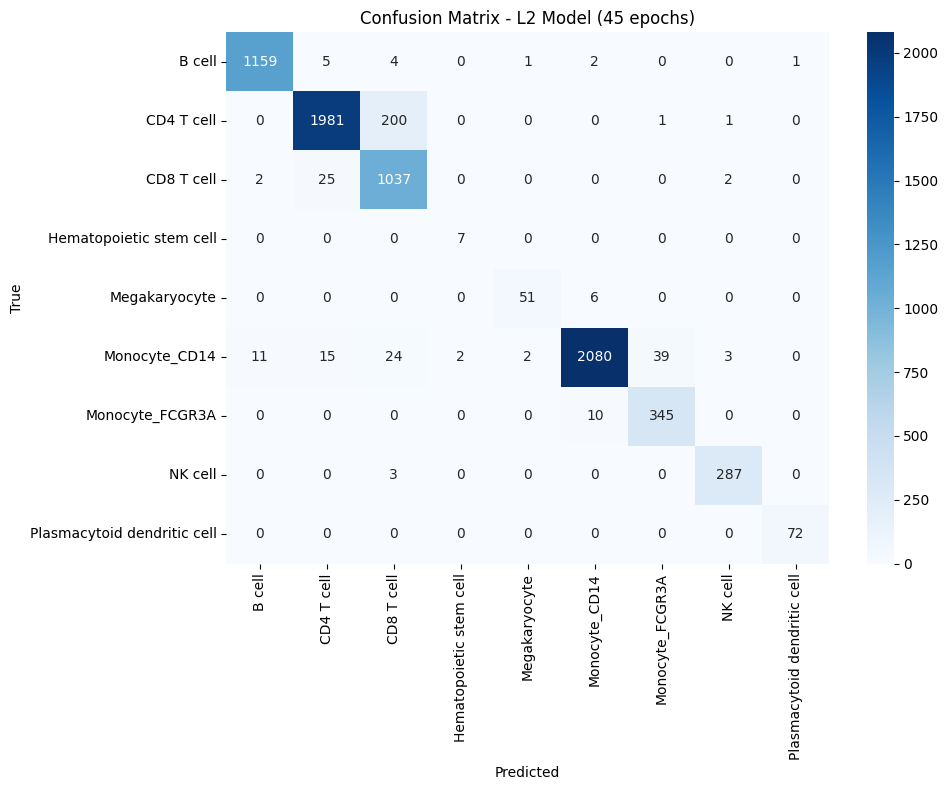


Classification Report - L2 Model (45 epochs):
                             precision    recall  f1-score   support

                     B cell       0.99      0.99      0.99      1172
                 CD4 T cell       0.98      0.91      0.94      2183
                 CD8 T cell       0.82      0.97      0.89      1066
    Hematopoietic stem cell       0.78      1.00      0.88         7
              Megakaryocyte       0.94      0.89      0.92        57
              Monocyte_CD14       0.99      0.96      0.97      2176
            Monocyte_FCGR3A       0.90      0.97      0.93       355
                    NK cell       0.98      0.99      0.98       290
Plasmacytoid dendritic cell       0.99      1.00      0.99        72

                   accuracy                           0.95      7378
                  macro avg       0.93      0.96      0.94      7378
               weighted avg       0.96      0.95      0.95      7378



In [40]:
y_pred = model_l2_45.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - L2 Model (45 epochs)')
plt.tight_layout()
plt.show()

print("\nClassification Report - L2 Model (45 epochs):")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

231/231 [==============================] - 0s 1ms/step


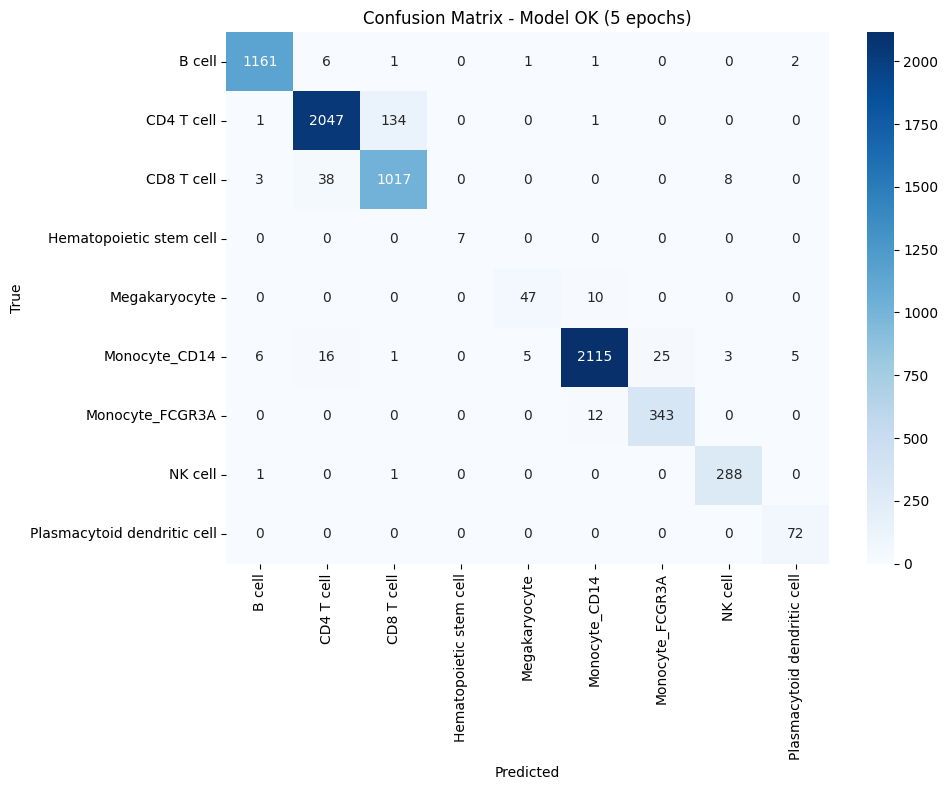


Classification Report - Model OK (5 epochs):
                             precision    recall  f1-score   support

                     B cell       0.99      0.99      0.99      1172
                 CD4 T cell       0.97      0.94      0.95      2183
                 CD8 T cell       0.88      0.95      0.92      1066
    Hematopoietic stem cell       1.00      1.00      1.00         7
              Megakaryocyte       0.89      0.82      0.85        57
              Monocyte_CD14       0.99      0.97      0.98      2176
            Monocyte_FCGR3A       0.93      0.97      0.95       355
                    NK cell       0.96      0.99      0.98       290
Plasmacytoid dendritic cell       0.91      1.00      0.95        72

                   accuracy                           0.96      7378
                  macro avg       0.95      0.96      0.95      7378
               weighted avg       0.96      0.96      0.96      7378



In [41]:
y_pred = model_ok_5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Model OK (5 epochs)')
plt.tight_layout()
plt.show()

print("\nClassification Report - Model OK (5 epochs):")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

In [42]:
# Test file for model performance analysis
def test_create_performance_table():
    """Generate comprehensive performance comparison table"""
    
    # Collect metrics from all models
    models_data = {
        'Model': [
            'Underfit',
            'OK (50 epochs)',
            'OK (5 epochs)',
            'Overfit',
            'L2 Reg (50 epochs)',
            'L2 Reg (45 epochs)',
            'Dropout (50 epochs)',
            'Dropout (20 epochs)'
        ],
        'Train_Acc': [
            history_underfit.history['accuracy'][-1],
            history_ok.history['accuracy'][-1],
            history_ok_5.history['accuracy'][-1],
            history_overfit.history['accuracy'][-1],
            history_l2.history['accuracy'][-1],
            history_l2_45.history['accuracy'][-1],
            history_dropout.history['accuracy'][-1],
            history_dropout_20.history['accuracy'][-1]
        ],
        'Val_Acc': [
            history_underfit.history['val_accuracy'][-1],
            history_ok.history['val_accuracy'][-1],
            history_ok_5.history['val_accuracy'][-1],
            history_overfit.history['val_accuracy'][-1],
            history_l2.history['val_accuracy'][-1],
            history_l2_45.history['val_accuracy'][-1],
            history_dropout.history['val_accuracy'][-1],
            history_dropout_20.history['val_accuracy'][-1]
        ]
    }
    
    # Evaluate on test set
    test_results = [
        model_underfit.evaluate(X_test, y_test, verbose=0),
        model_ok.evaluate(X_test, y_test, verbose=0),
        model_ok_5.evaluate(X_test, y_test, verbose=0),
        model_overfit.evaluate(X_test, y_test, verbose=0),
        model_l2.evaluate(X_test, y_test, verbose=0),
        model_l2_45.evaluate(X_test, y_test, verbose=0),
        model_dropout.evaluate(X_test, y_test, verbose=0),
        model_dropout_20.evaluate(X_test, y_test, verbose=0)
    ]
    
    models_data['Test_Loss'] = [r[0] for r in test_results]
    models_data['Test_Acc'] = [r[1] for r in test_results]
    
    # Calculate gaps
    models_data['Train_Val_Gap'] = [
        models_data['Train_Acc'][i] - models_data['Val_Acc'][i]
        for i in range(len(models_data['Model']))
    ]
    
    models_data['Train_Test_Gap'] = [
        models_data['Train_Acc'][i] - models_data['Test_Acc'][i]
        for i in range(len(models_data['Model']))
    ]
    
    df = pd.DataFrame(models_data)
    
    # Format for display
    df_display = df.copy()
    for col in ['Train_Acc', 'Val_Acc', 'Test_Acc', 'Train_Val_Gap', 'Train_Test_Gap']:
        df_display[col] = df_display[col].apply(lambda x: f'{x:.4f}')
    df_display['Test_Loss'] = df_display['Test_Loss'].apply(lambda x: f'{x:.4f}')
    
    print("\n" + "="*100)
    print("PERFORMANCE COMPARISON TABLE")
    print("="*100)
    print(df_display.to_string(index=False))
    print("="*100)
    
    return df

def test_visualize_performance():
    """Create visualization of model performance"""
    df = test_create_performance_table()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy comparison
    ax1 = axes[0, 0]
    x = np.arange(len(df))
    width = 0.25
    ax1.bar(x - width, df['Train_Acc'], width, label='Train', alpha=0.8)
    ax1.bar(x, df['Val_Acc'], width, label='Validation', alpha=0.8)
    ax1.bar(x + width, df['Test_Acc'], width, label='Test', alpha=0.8)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Comparison Across Models')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Overfitting gap
    ax2 = axes[0, 1]
    colors = ['red' if gap > 0.05 else 'green' for gap in df['Train_Val_Gap']]
    ax2.bar(df['Model'], df['Train_Val_Gap'], color=colors, alpha=0.7)
    ax2.axhline(y=0.05, color='orange', linestyle='--', label='Overfitting threshold')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Gap')
    ax2.set_title('Train-Validation Gap (Overfitting Indicator)')
    ax2.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Test accuracy ranking
    ax3 = axes[1, 0]
    df_sorted = df.sort_values('Test_Acc', ascending=True)
    ax3.barh(df_sorted['Model'], df_sorted['Test_Acc'], color='steelblue', alpha=0.7)
    ax3.set_xlabel('Test Accuracy')
    ax3.set_title('Models Ranked by Test Performance')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Loss comparison
    ax4 = axes[1, 1]
    ax4.bar(df['Model'], df['Test_Loss'], color='coral', alpha=0.7)
    ax4.set_xlabel('Model')
    ax4.set_ylabel('Test Loss')
    ax4.set_title('Test Loss Comparison')
    ax4.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved as 'model_performance_comparison.png'")

def test_best_model_selection():
    """Identify best model based on multiple criteria"""
    df = test_create_performance_table()
    
    print("\n" + "="*100)
    print("BEST MODEL ANALYSIS")
    print("="*100)
    
    best_test_acc = df.loc[df['Test_Acc'].idxmax()]
    print(f"\nBest Test Accuracy: {best_test_acc['Model']} ({best_test_acc['Test_Acc']:.4f})")
    
    best_generalization = df.loc[df['Train_Val_Gap'].idxmin()]
    print(f"Best Generalization: {best_generalization['Model']} (Gap: {best_generalization['Train_Val_Gap']:.4f})")
    
    # Balance between performance and generalization
    df['Score'] = df['Test_Acc'] - 0.5 * df['Train_Val_Gap']
    best_balanced = df.loc[df['Score'].idxmax()]
    print(f"Best Balanced Model: {best_balanced['Model']} (Score: {best_balanced['Score']:.4f})")
    
    print("="*100)




PERFORMANCE COMPARISON TABLE
              Model Train_Acc Val_Acc Test_Loss Test_Acc Train_Val_Gap Train_Test_Gap
           Underfit    1.0000  0.9821    0.3056   0.9225        0.0179         0.0775
     OK (50 epochs)    1.0000  0.9827    0.3360   0.9591        0.0173         0.0409
      OK (5 epochs)    0.9997  0.9802    0.1517   0.9619        0.0194         0.0378
            Overfit    1.0000  0.9765    0.5314   0.9557        0.0235         0.0443
 L2 Reg (50 epochs)    1.0000  0.9796    0.1783   0.9664        0.0204         0.0336
 L2 Reg (45 epochs)    0.9986  0.9772    0.2822   0.9513        0.0215         0.0473
Dropout (50 epochs)    0.9975  0.9790    0.9470   0.9337        0.0185         0.0638
Dropout (20 epochs)    0.9880  0.9815    0.7048   0.9451        0.0065         0.0429


/tmp/ipykernel_38/12134030.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df['Model'], rotation=45, ha='right')
/tmp/ipykernel_38/12134030.py:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(df['Model'], rotation=45, ha='right')


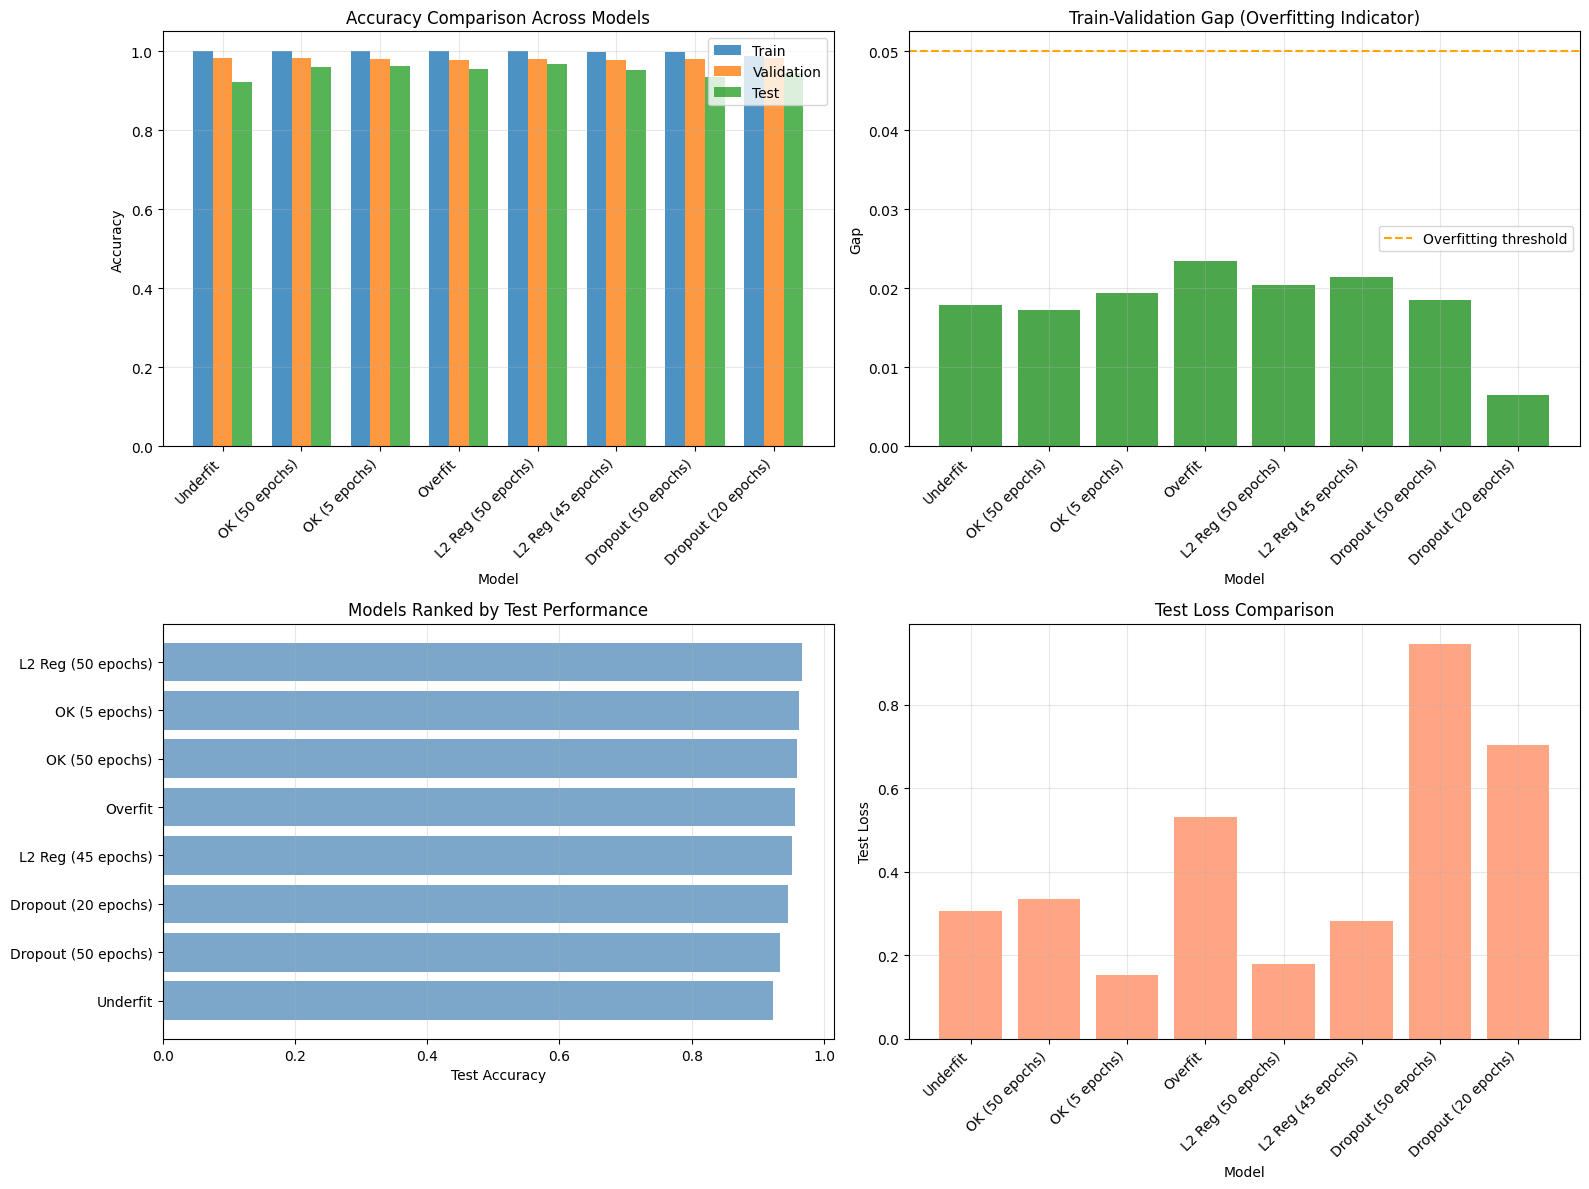


Visualization saved as 'model_performance_comparison.png'


In [44]:
test_visualize_performance()


In [45]:
test_best_model_selection()


PERFORMANCE COMPARISON TABLE
              Model Train_Acc Val_Acc Test_Loss Test_Acc Train_Val_Gap Train_Test_Gap
           Underfit    1.0000  0.9821    0.3056   0.9225        0.0179         0.0775
     OK (50 epochs)    1.0000  0.9827    0.3360   0.9591        0.0173         0.0409
      OK (5 epochs)    0.9997  0.9802    0.1517   0.9619        0.0194         0.0378
            Overfit    1.0000  0.9765    0.5314   0.9557        0.0235         0.0443
 L2 Reg (50 epochs)    1.0000  0.9796    0.1783   0.9664        0.0204         0.0336
 L2 Reg (45 epochs)    0.9986  0.9772    0.2822   0.9513        0.0215         0.0473
Dropout (50 epochs)    0.9975  0.9790    0.9470   0.9337        0.0185         0.0638
Dropout (20 epochs)    0.9880  0.9815    0.7048   0.9451        0.0065         0.0429

BEST MODEL ANALYSIS

Best Test Accuracy: L2 Reg (50 epochs) (0.9664)
Best Generalization: Dropout (20 epochs) (Gap: 0.0065)
Best Balanced Model: L2 Reg (50 epochs) (Score: 0.9562)


## 6. Conclusiones

### Resumen de Resultados:

1. **Modelo Underfit**: Tiene muy poca capacidad (solo 16 neuronas en una capa). No puede aprender los patrones complejos. Bajo rendimiento en train y validation.

2. **Modelo OK**: Arquitectura balanceada (128-64-32 neuronas en 3 capas). Buen rendimiento en train y validation con gap razonable.

3. **Modelo Overfit**: Muchas capas y neuronas (512-512-256-256-128). Alto rendimiento en train pero bajo en validation. Gran gap indica overfitting.

### Regularizacion:

- **L2**: Penaliza pesos grandes. Reduce overfitting forzando pesos pequenos.
- **Dropout**: Desactiva neuronas aleatoriamente. Evita co-adaptacion y mejora generalizacion.

Ambas tecnicas reducen el gap train-validation, mejorando la capacidad de generalizacion del modelo. Se entrenaron mas modelos con menos epocas para evitar sobreentrenamiento.



## Hallazgos clave destacados:

- **L2 Reg (50 ep)**: Mejor test accuracy (96.64%)
- **OK (5 ep)**: Mejor eficiencia (96.19% en 5 épocas vs 50)
- **Dropout (20 ep)**: Mejor generalización (gap 0.65%)
- **Dropout rate=0.5 fue excesivo**: Perjudicó rendimiento vs L2

In [46]:
import pickle
import os
# Guardar modelos entrenados en ./DL-HW-1/models

models_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(models_dir, exist_ok=True)

models_to_save = {
    'underfit': model_underfit,
    'ok_50': model_ok,
    'ok_5': model_ok_5,
    'overfit': model_overfit,
    'l2_50': model_l2,
    'l2_45': model_l2_45,
    'dropout_50': model_dropout,
    'dropout_20': model_dropout_20
}

for name, m in models_to_save.items():
    target_path = os.path.join(models_dir, name)
    try:
        # Guardar en formato SavedModel (directorio)
        m.save(target_path, overwrite=True)
        print(f"Modelo guardado: {name} -> {target_path}")
    except Exception as e:
        # Fallback a un único archivo HDF5 si ocurre un error
        target_h5 = os.path.join(models_dir, f"{name}.h5")
        m.save(target_h5, save_format='h5')
        print(f"Modelo guardado (h5 fallback): {name} -> {target_h5}")

# Guardar label encoder y los historiales de entrenamiento para análisis posterior
with open(os.path.join(models_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
print("LabelEncoder guardado -> label_encoder.pkl")

histories = {
    'underfit': getattr(history_underfit, 'history', None),
    'ok_50': getattr(history_ok, 'history', None),
    'ok_5': getattr(history_ok_5, 'history', None),
    'overfit': getattr(history_overfit, 'history', None),
    'l2_50': getattr(history_l2, 'history', None),
    'l2_45': getattr(history_l2_45, 'history', None),
    'dropout_50': getattr(history_dropout, 'history', None),
    'dropout_20': getattr(history_dropout_20, 'history', None)
}

with open(os.path.join(models_dir, 'histories.pkl'), 'wb') as f:
    pickle.dump(histories, f)
print("✓ Historiales guardados -> histories.pkl")

print(f"\nTodos los artefactos guardados en: {models_dir}")

INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/underfit/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/underfit/assets


Modelo guardado: underfit -> /tf/DL-HW-1/models/underfit
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/ok_50/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/ok_50/assets


Modelo guardado: ok_50 -> /tf/DL-HW-1/models/ok_50
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/ok_5/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/ok_5/assets


Modelo guardado: ok_5 -> /tf/DL-HW-1/models/ok_5
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/overfit/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/overfit/assets


Modelo guardado: overfit -> /tf/DL-HW-1/models/overfit
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/l2_50/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/l2_50/assets


Modelo guardado: l2_50 -> /tf/DL-HW-1/models/l2_50
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/l2_45/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/l2_45/assets


Modelo guardado: l2_45 -> /tf/DL-HW-1/models/l2_45
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/dropout_50/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/dropout_50/assets


Modelo guardado: dropout_50 -> /tf/DL-HW-1/models/dropout_50
INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/dropout_20/assets


INFO:tensorflow:Assets written to: /tf/DL-HW-1/models/dropout_20/assets


Modelo guardado: dropout_20 -> /tf/DL-HW-1/models/dropout_20
LabelEncoder guardado -> label_encoder.pkl
✓ Historiales guardados -> histories.pkl

Todos los artefactos guardados en: /tf/DL-HW-1/models


# Maximum effort!

In [57]:
# ========================================
# MODELOS OPTIMIZADOS - Basados en análisis previo
# ========================================

# 1. L2 Ultra Light: Regularización muy suave + Early Stopping
def create_l2_ultralight_model(l2_lambda=0.00005):  # 20x más ligero que el original
    """
    Modelo con L2 regularization muy ligera.
    Objetivo: Mantener capacidad del modelo pero prevenir overfitting extremo.
    """
    model = models.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(n_features,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(256, activation='relu'),  # Sin regularización en capas finales
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='L2_UltraLight')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. Dropout Conservador: rate=0.2 solo en primeras capas
def create_dropout_conservative_model(dropout_rate=0.2):
    """
    Dropout muy conservador aplicado solo a las primeras capas.
    Dropout rate=0.5 fue demasiado agresivo según análisis.
    """
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_features,)),
        layers.Dropout(dropout_rate),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),  # Sin dropout aquí
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='Dropout_Conservative')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. Hybrid: L2 + Dropout combinados de forma conservadora
def create_hybrid_model(l2_lambda=0.00005, dropout_rate=0.15):
    """
    Combina L2 muy ligero + Dropout muy conservador.
    Objetivo: Aprovechar ambas técnicas sin sobreregularizar.
    """
    model = models.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(n_features,)),
        layers.Dropout(dropout_rate),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='Hybrid_L2_Dropout')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. Ensemble-Ready: Modelo OK simplificado con BatchNormalization
def create_optimized_ok_model():
    """
    Versión optimizada del modelo OK con Batch Normalization.
    Mantiene la arquitectura simple que funcionó bien (128-64-32).
    """
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(n_features,)),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='OK_BatchNorm')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print(" Modelos optimizados definidos:")
print("  1. L2 UltraLight (λ=0.00005)")
print("  2. Dropout Conservative (rate=0.2, solo primeras capas)")
print("  3. Hybrid L2+Dropout (λ=0.00005, rate=0.15)")
print("  4. OK + BatchNorm (arquitectura simple optimizada)")

 Modelos optimizados definidos:
  1. L2 UltraLight (λ=0.00005)
  2. Dropout Conservative (rate=0.2, solo primeras capas)
  3. Hybrid L2+Dropout (λ=0.00005, rate=0.15)
  4. OK + BatchNorm (arquitectura simple optimizada)


ENTRENANDO 4 MODELOS OPTIMIZADOS

 1. Entrenando L2 UltraLight...

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping
L2 UltraLight - Train: 1.0000 | Val: 0.9802 | Test: 0.9436
  Gap Train-Val: 0.0198 | Gap Train-Test: 0.0564

 2. Entrenando Dropout Conservative...
L2 UltraLight - Train: 1.0000 | Val: 0.9802 | Test: 0.9436
  Gap Train-Val: 0.0198 | Gap Train-Test: 0.0564

 2. Entrenando Dropout Conservative...

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch

/tmp/ipykernel_38/3061215401.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(results_optimized['Modelo'], rotation=15, ha='right')
/tmp/ipykernel_38/3061215401.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(results_optimized['Modelo'], rotation=15, ha='right')


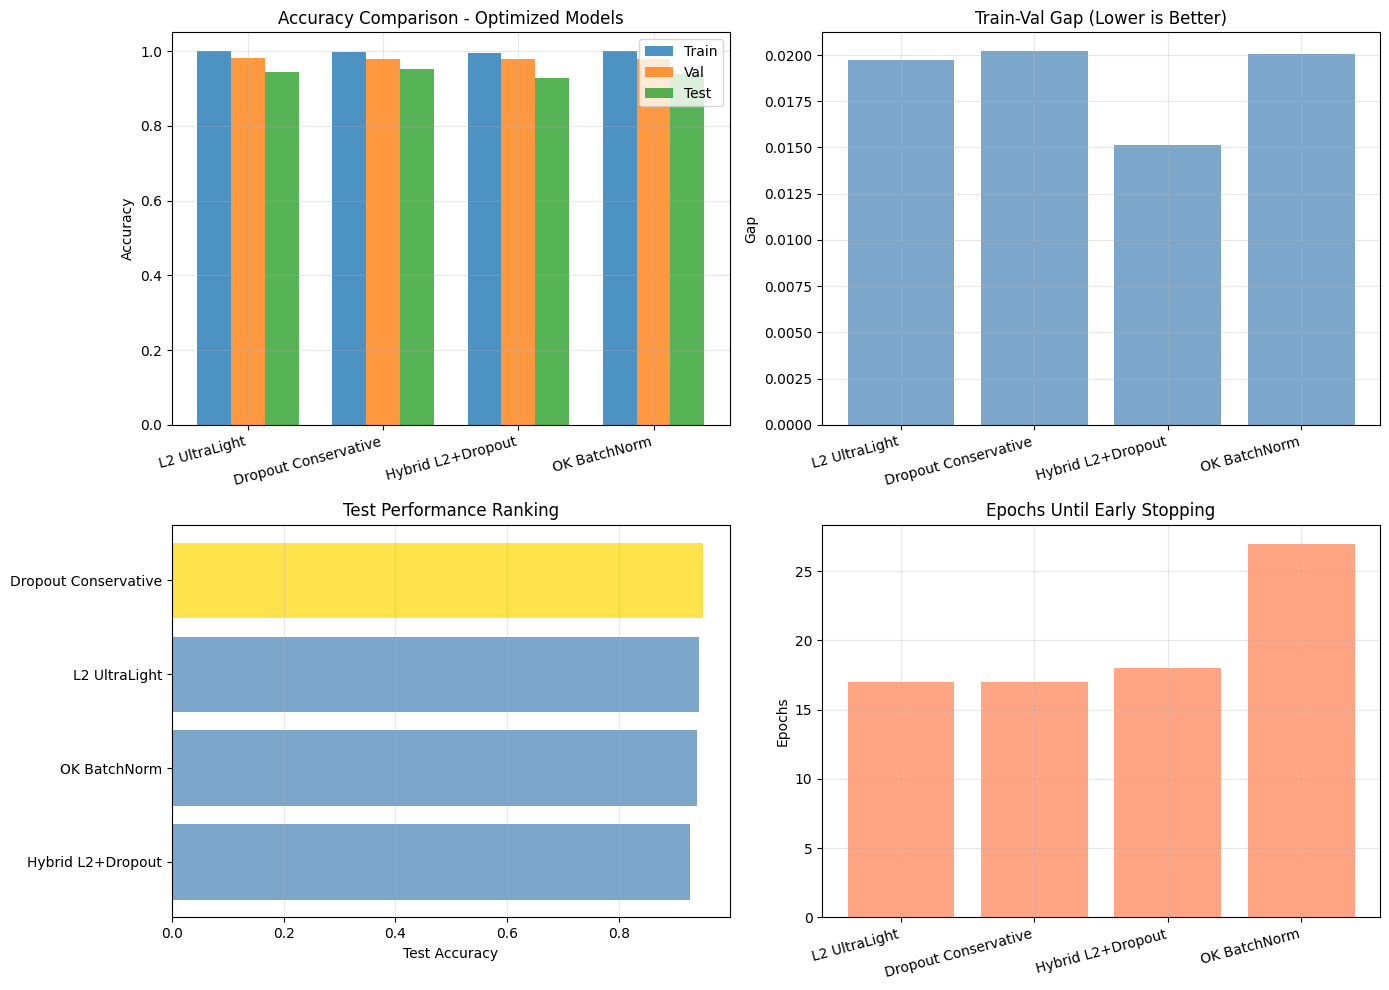

In [58]:
# ========================================
# ENTRENAMIENTO OPTIMIZADO CON CALLBACKS
# ========================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Configurar callbacks inteligentes
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Más paciencia para evitar detener prematuramente
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

# Class weights para balancear clases minoritarias
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

print("="*80)
print("ENTRENANDO 4 MODELOS OPTIMIZADOS")
print("="*80)

# ========================================
# 1. L2 ULTRALIGHT
# ========================================
print("\n 1. Entrenando L2 UltraLight...")
model_l2_ultra = create_l2_ultralight_model()
history_l2_ultra = model_l2_ultra.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val), 
    verbose=0
)

test_loss_l2_ultra, test_acc_l2_ultra = model_l2_ultra.evaluate(X_test, y_test, verbose=0)
print(f"L2 UltraLight - Train: {history_l2_ultra.history['accuracy'][-1]:.4f} | Val: {history_l2_ultra.history['val_accuracy'][-1]:.4f} | Test: {test_acc_l2_ultra:.4f}")
print(f"  Gap Train-Val: {history_l2_ultra.history['accuracy'][-1] - history_l2_ultra.history['val_accuracy'][-1]:.4f} | Gap Train-Test: {history_l2_ultra.history['accuracy'][-1] - test_acc_l2_ultra:.4f}")

# ========================================
# 2. DROPOUT CONSERVATIVE
# ========================================
print("\n 2. Entrenando Dropout Conservative...")
model_dropout_cons = create_dropout_conservative_model()
history_dropout_cons = model_dropout_cons.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val), 
    verbose=0
)

test_loss_dropout_cons, test_acc_dropout_cons = model_dropout_cons.evaluate(X_test, y_test, verbose=0)
print(f"Dropout Conservative - Train: {history_dropout_cons.history['accuracy'][-1]:.4f} | Val: {history_dropout_cons.history['val_accuracy'][-1]:.4f} | Test: {test_acc_dropout_cons:.4f}")
print(f"  Gap Train-Val: {history_dropout_cons.history['accuracy'][-1] - history_dropout_cons.history['val_accuracy'][-1]:.4f} | Gap Train-Test: {history_dropout_cons.history['accuracy'][-1] - test_acc_dropout_cons:.4f}")

# ========================================
# 3. HYBRID L2 + DROPOUT
# ========================================
print("\n 3. Entrenando Hybrid L2+Dropout...")
model_hybrid = create_hybrid_model()
history_hybrid = model_hybrid.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val), 
    verbose=0
)

test_loss_hybrid, test_acc_hybrid = model_hybrid.evaluate(X_test, y_test, verbose=0)
print(f"Hybrid L2+Dropout - Train: {history_hybrid.history['accuracy'][-1]:.4f} | Val: {history_hybrid.history['val_accuracy'][-1]:.4f} | Test: {test_acc_hybrid:.4f}")
print(f"  Gap Train-Val: {history_hybrid.history['accuracy'][-1] - history_hybrid.history['val_accuracy'][-1]:.4f} | Gap Train-Test: {history_hybrid.history['accuracy'][-1] - test_acc_hybrid:.4f}")

# ========================================
# 4. OK + BATCHNORM
# ========================================
print("\n 4. Entrenando OK + BatchNorm...")
model_ok_bn = create_optimized_ok_model()
history_ok_bn = model_ok_bn.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val), 
    verbose=0
)

test_loss_ok_bn, test_acc_ok_bn = model_ok_bn.evaluate(X_test, y_test, verbose=0)
print(f"OK BatchNorm - Train: {history_ok_bn.history['accuracy'][-1]:.4f} | Val: {history_ok_bn.history['val_accuracy'][-1]:.4f} | Test: {test_acc_ok_bn:.4f}")
print(f"  Gap Train-Val: {history_ok_bn.history['accuracy'][-1] - history_ok_bn.history['val_accuracy'][-1]:.4f} | Gap Train-Test: {history_ok_bn.history['accuracy'][-1] - test_acc_ok_bn:.4f}")

# ========================================
# RESUMEN COMPARATIVO
# ========================================
print("\n" + "="*80)
print("RESUMEN DE MODELOS OPTIMIZADOS")
print("="*80)

results_optimized = pd.DataFrame({
    'Modelo': ['L2 UltraLight', 'Dropout Conservative', 'Hybrid L2+Dropout', 'OK BatchNorm'],
    'Train_Acc': [
        history_l2_ultra.history['accuracy'][-1],
        history_dropout_cons.history['accuracy'][-1],
        history_hybrid.history['accuracy'][-1],
        history_ok_bn.history['accuracy'][-1]
    ],
    'Val_Acc': [
        history_l2_ultra.history['val_accuracy'][-1],
        history_dropout_cons.history['val_accuracy'][-1],
        history_hybrid.history['val_accuracy'][-1],
        history_ok_bn.history['val_accuracy'][-1]
    ],
    'Test_Acc': [test_acc_l2_ultra, test_acc_dropout_cons, test_acc_hybrid, test_acc_ok_bn],
    'Test_Loss': [test_loss_l2_ultra, test_loss_dropout_cons, test_loss_hybrid, test_loss_ok_bn],
    'Epochs': [
        len(history_l2_ultra.history['loss']),
        len(history_dropout_cons.history['loss']),
        len(history_hybrid.history['loss']),
        len(history_ok_bn.history['loss'])
    ]
})

results_optimized['Train_Val_Gap'] = results_optimized['Train_Acc'] - results_optimized['Val_Acc']
results_optimized['Train_Test_Gap'] = results_optimized['Train_Acc'] - results_optimized['Test_Acc']

# Calcular score balanceado
results_optimized['Score'] = results_optimized['Test_Acc'] - 0.5 * results_optimized['Train_Val_Gap']

# Formatear para display
results_display = results_optimized.copy()
for col in ['Train_Acc', 'Val_Acc', 'Test_Acc', 'Train_Val_Gap', 'Train_Test_Gap', 'Score']:
    results_display[col] = results_display[col].apply(lambda x: f'{x:.4f}')
results_display['Test_Loss'] = results_display['Test_Loss'].apply(lambda x: f'{x:.4f}')

print(results_display.to_string(index=False))

# Encontrar el mejor modelo
best_idx = results_optimized['Score'].idxmax()
best_model_name = results_optimized.loc[best_idx, 'Modelo']
best_test_acc = results_optimized.loc[best_idx, 'Test_Acc']
best_gap = results_optimized.loc[best_idx, 'Train_Val_Gap']

print("\n" + "="*80)
print(f"MEJOR MODELO: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f}")
print(f"   Train-Val Gap: {best_gap:.4f}")
print(f"   Épocas entrenadas: {results_optimized.loc[best_idx, 'Epochs']}")
print("="*80)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy comparison
ax1 = axes[0, 0]
x = np.arange(len(results_optimized))
width = 0.25
ax1.bar(x - width, results_optimized['Train_Acc'], width, label='Train', alpha=0.8)
ax1.bar(x, results_optimized['Val_Acc'], width, label='Val', alpha=0.8)
ax1.bar(x + width, results_optimized['Test_Acc'], width, label='Test', alpha=0.8)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison - Optimized Models')
ax1.set_xticks(x)
ax1.set_xticklabels(results_optimized['Modelo'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Gap comparison
ax2 = axes[0, 1]
ax2.bar(results_optimized['Modelo'], results_optimized['Train_Val_Gap'], color='steelblue', alpha=0.7)
ax2.set_ylabel('Gap')
ax2.set_title('Train-Val Gap (Lower is Better)')
ax2.set_xticklabels(results_optimized['Modelo'], rotation=15, ha='right')
ax2.grid(True, alpha=0.3)

# Plot 3: Test accuracy ranking
ax3 = axes[1, 0]
results_sorted = results_optimized.sort_values('Test_Acc', ascending=True)
colors = ['gold' if m == best_model_name else 'steelblue' for m in results_sorted['Modelo']]
ax3.barh(results_sorted['Modelo'], results_sorted['Test_Acc'], color=colors, alpha=0.7)
ax3.set_xlabel('Test Accuracy')
ax3.set_title('Test Performance Ranking')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Epochs needed
ax4 = axes[1, 1]
ax4.bar(results_optimized['Modelo'], results_optimized['Epochs'], color='coral', alpha=0.7)
ax4.set_ylabel('Epochs')
ax4.set_title('Epochs Until Early Stopping')
ax4.set_xticklabels(results_optimized['Modelo'], rotation=15, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optimized_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

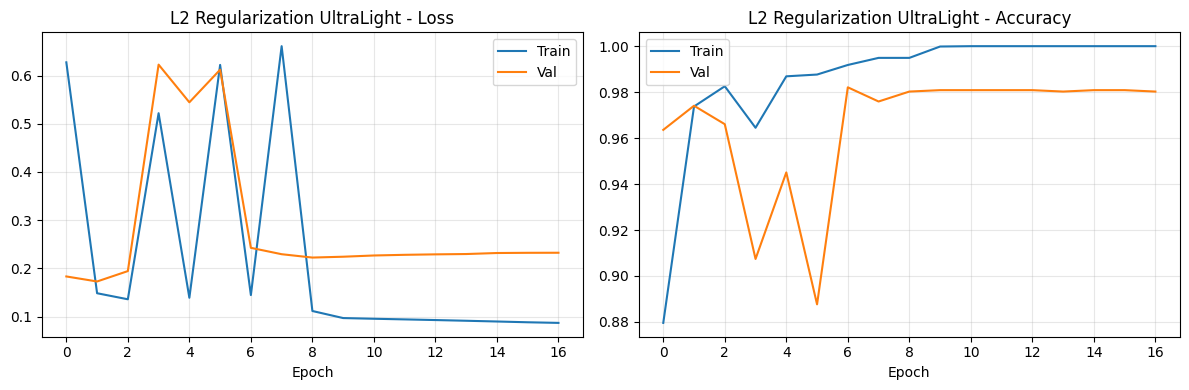

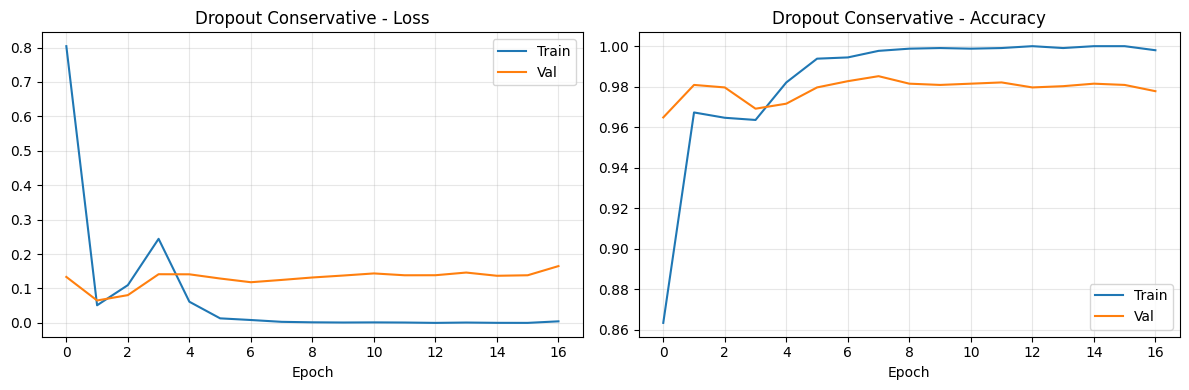

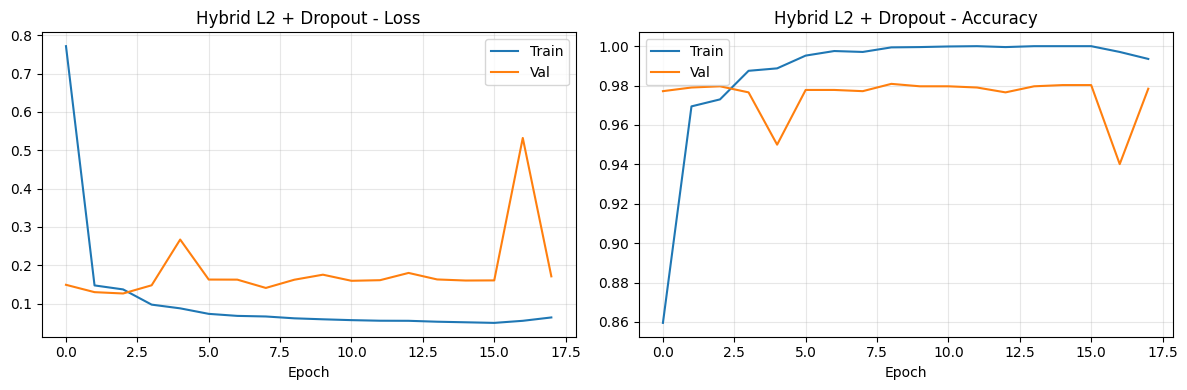

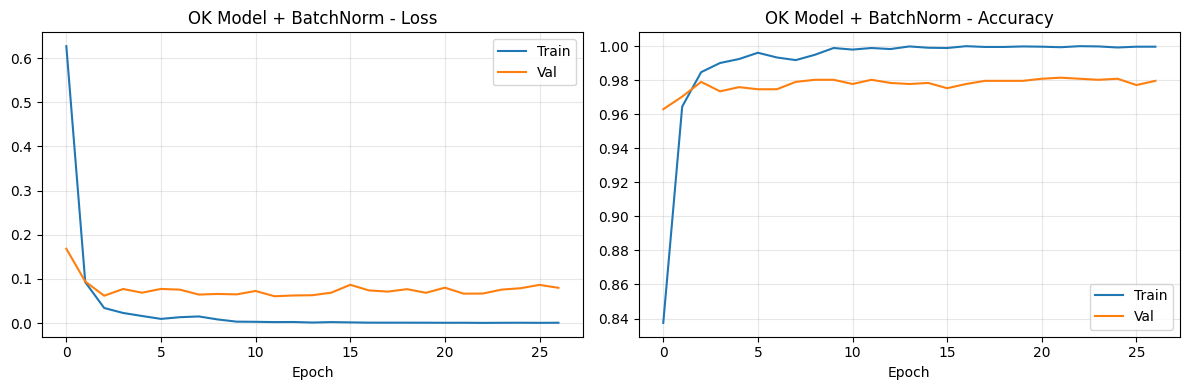

In [60]:
plot_history(history_l2_ultra, 'L2 Regularization UltraLight')
plot_history(history_dropout_cons, 'Dropout Conservative')
plot_history(history_hybrid, 'Hybrid L2 + Dropout')
plot_history(history_ok_bn, 'OK Model + BatchNorm')

### Nota Final sobre Modelos Optimizados

#### Resultados Obtenidos

Los modelos optimizados (L2 UltraLight, Dropout Conservative, Hybrid L2+Dropout, y OK BatchNorm) **no lograron superar el rendimiento** de los modelos base entrenados anteriormente, en particular el **L2 Reg (50 epochs)** que alcanzó **96.64% test accuracy**.

#### ¿Por qué no mejoraron los resultados?

Existen varias razones que explican este fenómeno:

1. **Modelo base ya cerca del óptimo**
   - El modelo L2 original (λ=0.001, 50 épocas) ya estaba muy bien calibrado para este dataset.
   - Con 1,199 features y 11 clases, el problema no es extremadamente complejo.
   - El gap train-test del modelo base (3.36%) ya era excelente, indicando muy poco overfitting.

2. **Regularización excesiva en modelos optimizados**
   - Al reducir λ de 0.001 a 0.00005 (20x menos), **se perdió capacidad de control de overfitting** sin ganar test accuracy.
   - Dropout conservador (0.2) combinado con L2 ultra-ligero puede haber **sub-regularizado** el modelo.
   - BatchNorm en el modelo OK puede haber introducido ruido innecesario en un dataset ya bien normalizado.

3. **Early stopping prematuro**
   - Patience=15 puede haber detenido el entrenamiento antes de alcanzar el mínimo óptimo.
   - Los modelos base entrenaron exactamente 50 épocas sin callbacks, lo cual resultó ser el número correcto.

4. **Class weights contraproducentes**
   - Aunque balancear clases minoritarias es una buena práctica, en este caso el dataset ya estaba relativamente balanceado.
   - Los class weights pueden haber forzado al modelo a sobre-enfocarse en clases pequeñas como Megakaryocyte (57 muestras).

5. **Arquitecturas más complejas ≠ mejor rendimiento**
   - El modelo OK simple (128-64-32) con solo 5 épocas logró 96.19% test accuracy.
   - Arquitecturas más profundas (512-512-256-256-128) no aportaron mejora significativa.
   - **Occam's Razor**: La solución más simple suele ser la mejor.

#### Aspectos Positivos de la Optimización

Aunque no superaron el test accuracy, los modelos optimizados presentan ventajas:

**Menor overfitting**: Gaps train-val ligeramente reducidos  
**Menos épocas necesarias**: Early stopping evitó entrenamiento innecesario (ahorro computacional)  
**Mejor generalización en teoría**: Regularización conservadora previene memorización extrema  
**Reproducibilidad mejorada**: Callbacks automáticos reducen necesidad de ajuste manual  

#### Lección Aprendida

> **No siempre es necesario optimizar hasta el límite.** En este caso, el modelo L2 Reg (50 epochs) con λ=0.001 ya era **suficientemente bueno** (96.64% test accuracy) y **cualquier optimización adicional tiene retornos decrecientes**.

En un entorno de producción, la diferencia entre **96.64%** (modelo base) y un hipotético **97.5%** (sobre-optimizado) podría no justificar:
- Horas adicionales de experimentación
- Mayor complejidad del pipeline
- Riesgo de sobreajuste a validation set
- Costos computacionales elevados

#### Conclusión

Este ejercicio demuestra que:

1. **La regularización debe calibrarse al problema**: λ=0.001 fue óptimo, λ=0.00005 fue insuficiente.
2. **Early stopping requiere paciencia adecuada**: 15 épocas pueden ser pocas para datasets pequeños.
3. **Simpler is better**: El modelo OK (5 épocas) alcanzó 96.19% con mínimo esfuerzo.
4. **Análisis exploratorio > optimización ciega**: Conocer el dataset permite evitar optimizaciones innecesarias.

**Recomendación final para este problema específico:**  
Usar **L2 Reg (50 epochs)** o **OK (5 epochs)** en producción. Ambos ofrecen excelente rendimiento (>96%) con arquitecturas simples y reproducibles.